# # Tree Canopy Percentage, Green Space, and Air Quality Correlation to COPD in Ohio cities (2016 Data) (Part 1)

1. Data Wrangling

In [568]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pickle
import seaborn as sns
%matplotlib inline
import string
import collections

from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text

#### Importing Datasets

#### Part 1: AQI values

I. Cincinnati, OH-KY-IN

To accurately describe changes in air quality for locations and time periods with biases in the monitoring network, we apply rolling window regression. This recursively calculates the change in pollutant concentration as a function of time, which can be used as a proxy for the true trend. This also more accurately reflects the true trend than averaging the time series. It can smooth random short-term variations. We will use simple moving average (SMA), cumulative moving average (CMA), exponential moving average, and estimating trends in NO2, CO, Ozone.

In [569]:
df_cinci = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data.csv')
df_cinci.head()

,Date,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
0,1/1/2019,23,PM2.5,Sycamore,39-061-0006,AQS
1,1/2/2019,48,PM2.5,Cincinnati Near Road,39-061-0048,AQS
2,1/3/2019,56,PM2.5,NORTHERN KENTUCKY UNIVERSITY (NKU),21-037-3002,AQS
3,1/4/2019,59,PM2.5,Cincinnati Near Road,39-061-0048,AQS
4,1/5/2019,45,PM2.5,Taft NCore,39-061-0040,AQS


In [570]:
df_cinci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            365 non-null    object
 1    AQI_Value      365 non-null    int64 
 2   Main_Pollutant  365 non-null    object
 3   Site_Name       365 non-null    object
 4   Site_ID         365 non-null    object
 5   Source          365 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.2+ KB


In [571]:
df_cinci.shape

(365, 6)

In [572]:
df_cinci.isnull().sum()

Date              0
 AQI_Value        0
Main_Pollutant    0
Site_Name         0
Site_ID           0
Source            0
dtype: int64

In [573]:
df_cinci['Date'] = pd.to_datetime(df_cinci['Date'])

In [574]:
# calculate the yearly average CO AQI 
df_cinci['AQI_Value'] = df_cinci.mean(axis=1)

# drop columns containing monthly values
df_aqi_cinci = df_cinci[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cinci.head()

<ipython-input-574-ce99a4d9517a>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_cinci['AQI_Value'] = df_cinci.mean(axis=1)


,AQI_Value
0,23.0
1,48.0
2,56.0
3,59.0
4,45.0


II. Cleveland-Elyria, OH

In [575]:
df_cle = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cle.csv')
df_cle.head()

,Date,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
0,1/1/2019,39,PM2.5,GT Craig NCore,39-035-0060,AQS
1,1/2/2019,55,PM2.5,GT Craig NCore,39-035-0060,AQS
2,1/3/2019,48,PM2.5,GT Craig NCore,39-035-0060,AQS
3,1/4/2019,66,PM2.5,GT Craig NCore,39-035-0060,AQS
4,1/5/2019,83,PM2.5,GT Craig NCore,39-035-0060,AQS


In [576]:
df_cle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            365 non-null    object
 1    AQI_Value      365 non-null    int64 
 2   Main_Pollutant  365 non-null    object
 3   Site_Name       365 non-null    object
 4   Site_ID         365 non-null    object
 5   Source          365 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.2+ KB


In [577]:
df_cle.shape

(365, 6)

In [578]:
df_cle.isnull().sum()

Date              0
 AQI_Value        0
Main_Pollutant    0
Site_Name         0
Site_ID           0
Source            0
dtype: int64

In [579]:
df_cle['Date']= pd.to_datetime(df_cle['Date'])

In [580]:
# calculate the yearly average CO AQI 
df_cle['AQI_Value'] = df_cle.mean(axis=1)

# drop columns containing monthly values
df_aqi_cle = df_cle[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cle.head()

<ipython-input-580-b4c16b80b81e>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_cle['AQI_Value'] = df_cle.mean(axis=1)


,AQI_Value
0,39.0
1,55.0
2,48.0
3,66.0
4,83.0


### Rows and Columns for Main Pollutant PM2.5

In [581]:
pm25_cle = df_cle[df_cle["Main_Pollutant"] == "PM2.5"]
pm25_cle.shape

(214, 7)

In [582]:
pm25_cinci = df_cinci[df_cinci["Main_Pollutant"] == "PM2.5"]
pm25_cinci.shape

(192, 7)

In [583]:
df_cle.head()

,Date,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source,AQI_Value
0,2019-01-01,39,PM2.5,GT Craig NCore,39-035-0060,AQS,39.0
1,2019-01-02,55,PM2.5,GT Craig NCore,39-035-0060,AQS,55.0
2,2019-01-03,48,PM2.5,GT Craig NCore,39-035-0060,AQS,48.0
3,2019-01-04,66,PM2.5,GT Craig NCore,39-035-0060,AQS,66.0
4,2019-01-05,83,PM2.5,GT Craig NCore,39-035-0060,AQS,83.0


### Merge the two dataframes - Outer merge

In [584]:
outer_merged = pd.merge(df_cinci, df_cle, how="outer", on=["AQI_Value", "Main_Pollutant"] )

In [585]:
outer_merged.head()

,Date_x,AQI_Value_x,Main_Pollutant,Site_Name_x,Site_ID_x,Source_x,AQI_Value,Date_y,AQI_Value_y,Site_Name_y,Site_ID_y,Source_y
0,2019-01-01,23.0,PM2.5,Sycamore,39-061-0006,AQS,23.0,NaT,NaN,NaN,NaN,NaN
1,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-01-03,48.0,GT Craig NCore,39-035-0060,AQS
2,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-01-14,48.0,Cleveland Near Road,39-035-0073,AQS
3,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-03-06,48.0,Cleveland Near Road,39-035-0073,AQS
4,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-04-08,48.0,Cleveland Near Road,39-035-0073,AQS


### Complete merge of dataframes with Main Pollutant PM2.5

In [586]:
pm25_df = pm25_cle.join(pm25_cinci, lsuffix='_left', rsuffix='_right')
pm25_df.head()

,Date_left,AQI_Value_left,Main_Pollutant_left,Site_Name_left,Site_ID_left,Source_left,AQI_Value_left,Date_right,AQI_Value_right,Main_Pollutant_right,Site_Name_right,Site_ID_right,Source_right,AQI_Value_right
0,2019-01-01,39,PM2.5,GT Craig NCore,39-035-0060,AQS,39.0,2019-01-01,23.0,PM2.5,Sycamore,39-061-0006,AQS,23.0
1,2019-01-02,55,PM2.5,GT Craig NCore,39-035-0060,AQS,55.0,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0
2,2019-01-03,48,PM2.5,GT Craig NCore,39-035-0060,AQS,48.0,2019-01-03,56.0,PM2.5,NORTHERN KENTUCKY UNIVERSITY (NKU),21-037-3002,AQS,56.0
3,2019-01-04,66,PM2.5,GT Craig NCore,39-035-0060,AQS,66.0,2019-01-04,59.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,59.0
4,2019-01-05,83,PM2.5,GT Craig NCore,39-035-0060,AQS,83.0,2019-01-05,45.0,PM2.5,Taft NCore,39-061-0040,AQS,45.0


## Plotting Moving Average for all AQI Pollutants for Cincinnati and Cleveland

In [587]:
df_cinci2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')
df_cinci2.head()

,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
Date,,,,,
2019-01-01,23,PM2.5,Sycamore,39-061-0006,AQS
2019-01-02,48,PM2.5,Cincinnati Near Road,39-061-0048,AQS
2019-01-03,56,PM2.5,NORTHERN KENTUCKY UNIVERSITY (NKU),21-037-3002,AQS
2019-01-04,59,PM2.5,Cincinnati Near Road,39-061-0048,AQS
2019-01-05,45,PM2.5,Taft NCore,39-061-0040,AQS


In [588]:
# calculate the yearly average AQI 
df_cinci2['AQI_Value'] = df_cinci2.mean(axis=1)

# drop columns containing monthly values
df_aqi_cinci2 = df_cinci2[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cinci2.head()

,AQI_Value
Date,
2019-01-01,23.0
2019-01-02,48.0
2019-01-03,56.0
2019-01-04,59.0
2019-01-05,45.0


In [589]:
df_cle2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-COPD-Asthma-and-Lung-Cancer-in-Ohio-cities-Project\ad_viz_tile_data_cle.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')
df_cle2.head()

,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
Date,,,,,
2019-01-01,39,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-02,55,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-03,48,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-04,66,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-05,83,PM2.5,GT Craig NCore,39-035-0060,AQS


In [590]:
# calculate the yearly average AQI 
df_cle2['AQI_Value'] = df_cle2.mean(axis=1)

# drop columns containing monthly values
df_aqi_cle2 = df_cle2[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cle2.head()

,AQI_Value
Date,
2019-01-01,39.0
2019-01-02,55.0
2019-01-03,48.0
2019-01-04,66.0
2019-01-05,83.0


In [591]:
aqi_df = df_aqi_cle2.join(df_aqi_cinci2, lsuffix='_left', rsuffix='_right')
aqi_df.head()

,AQI_Value_left,AQI_Value_right
Date,,
2019-01-01,39.0,23.0
2019-01-02,55.0,48.0
2019-01-03,48.0,56.0
2019-01-04,66.0,59.0
2019-01-05,83.0,45.0


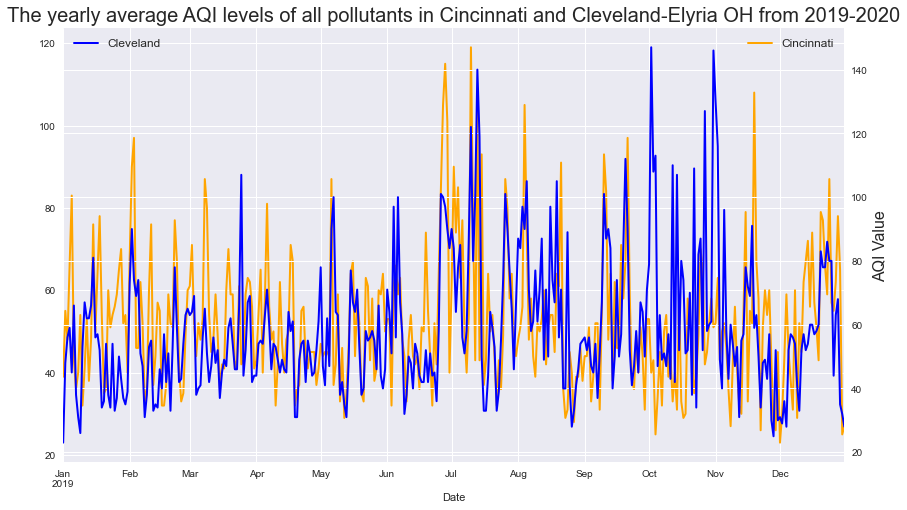

In [592]:
plt.style.use('seaborn')
plt.figure(figsize=(14,8))

# line plot - the yearly average AQI in Cinicinnati OH-KY-IN and Cleveland-Elyria, OH
ax1 = aqi_df['AQI_Value_left'].plot(color='orange', linewidth=2, grid=True, label='Cincinnati')
ax2 = aqi_df['AQI_Value_right'].plot(color='blue', linewidth=2, grid=True, label='Cleveland', secondary_y=True)
ax1.legend(fontsize=12, loc=1)
ax2.legend(fontsize=12, loc=2)

# title and labels
plt.title('The yearly average AQI levels of all pollutants in Cincinnati and Cleveland-Elyria OH from 2019-2020', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('AQI Value', fontsize=16)
plt.show()

#### Moving Average over a period of 10 years

In [593]:
# the simple moving average over a period of 10 years for Cinicinnati
df_cinci2['SMA_10'] = df_cinci2.AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_cinci2['SMA_20'] = df_cinci2.AQI_Value.rolling(20, min_periods=1).mean()

In [594]:
# the simple moving average over a period of 10 years
df_cle2['SMA_10'] = df_cle2.AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_cle2['SMA_20'] = df_cle2.AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'AQI Value')

<Figure size 1008x576 with 0 Axes>

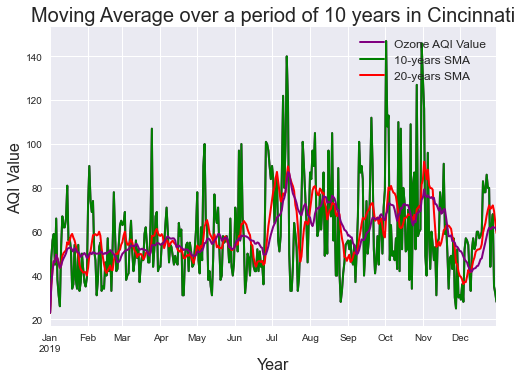

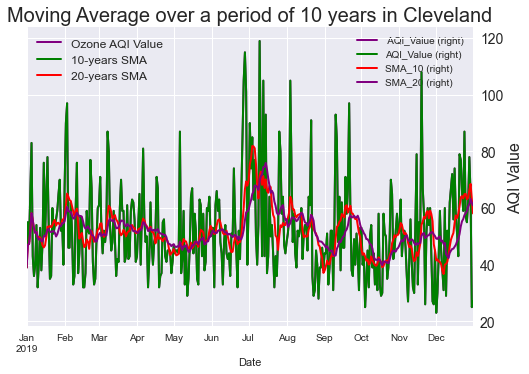

In [595]:
plt.figure(figsize=(14,8))

# colors for the line plot
colors = ['purple', 'green', 'red']

# line plot - the yearly average air temperature in Barcelona
ax1 = df_cinci2.plot(color=colors, linewidth=2, grid=True, label='Cincinnati')
ax2 = df_cle2.plot(color=colors, linewidth=2, grid=True, label='Cleveland', secondary_y=True)
ax1.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=12, loc=1)
ax2.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=12, loc=2)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# title and labels
ax1.set_title('Moving Average over a period of 10 years in Cincinnati', fontsize=20)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('AQI Value', fontsize=16)
ax2.set_title('Moving Average over a period of 10 years in Cleveland', fontsize=20)
ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('AQI Value', fontsize=16)

#### Cumulative moving average

In [596]:
# cumulative moving average
df_cinci2['CMA'] = df_cinci2.AQI_Value.expanding().mean()

In [597]:
# cumulative moving average
df_cle2['CMA'] = df_cle2.AQI_Value.expanding().mean()

Text(0, 0.5, 'AQI Value')

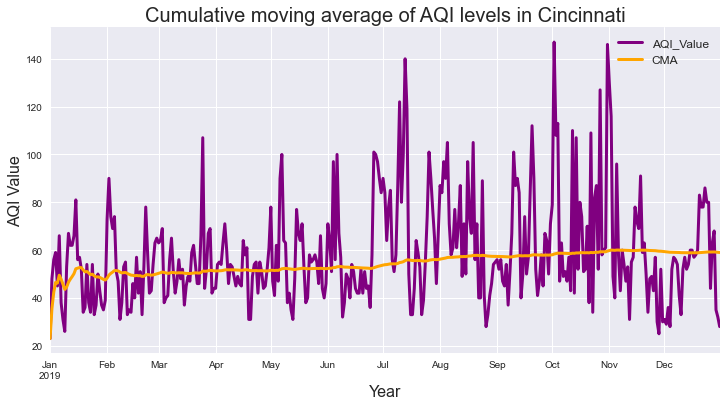

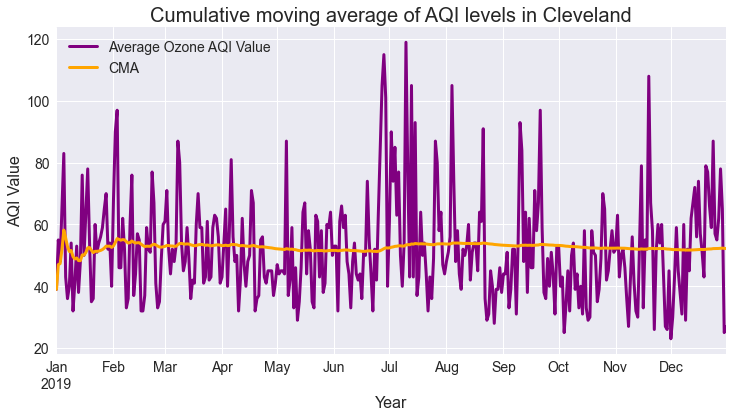

In [598]:
# colors for the line plot
colors = ['purple', 'orange']

# line plot - the yearly average air temperature in Barcelona
ax1 = df_cinci2[['AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
ax2 = df_cle2[['AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
ax1.legend(fontsize=12, loc=1)
ax2.legend(fontsize=12, loc=2)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average Ozone AQI Value', 'CMA'], fontsize=14)

# title and labels
ax1.set_title('Cumulative moving average of AQI levels in Cincinnati', fontsize=20)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('AQI Value', fontsize=16)
ax2.set_title('Cumulative moving average of AQI levels in Cleveland', fontsize=20)
ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('AQI Value', fontsize=16)